In [1]:
%matplotlib inline

import multiprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:
df = pd.read_json('babynames.jl', lines=True)
df.sample(10)

,name,meaning,gender,ethnicity
3328,basinah,"Kitty, kitten",girl,muslim
6103,gulhaar,Flower Distributor,boy,muslim
17821,turanum,Sing Softly,girl,muslim
17137,talbaa,High,girl,muslim
16414,silsaal,Sweet Water,girl,muslim
842,afrida,"Created, Produced.",girl,muslim
9757,luloah,"Variant Of Lu'lu: Pearls, Gems.",girl,muslim
11355,murshidah,Guide,girl,muslim
818,afmar,Crown,girl,muslim
11259,munnay,Little,girl,muslim


In [3]:
letters = sorted(list(set(''.join(df.name.tolist()))))
print(letters)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
START_CHAR = '<START>'
END_CHAR = '<END>'
MALE_CHAR = '<MALE>'
FEMALE_CHAR = '<FEMALE>'

VOCAB = [START_CHAR, END_CHAR, MALE_CHAR, FEMALE_CHAR] + letters
VOCAB_SIZE = len(VOCAB)
EMB_DIM = 32 
CONTEXT_DIM = 4

print(VOCAB, len(VOCAB))

['<START>', '<END>', '<MALE>', '<FEMALE>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 30


In [5]:
ltoi = {l: i for i, l in enumerate(VOCAB)}
itol = {i:l for l, i in ltoi.items()} 
print(ltoi)
print(itol)

{'<START>': 0, '<END>': 1, '<MALE>': 2, '<FEMALE>': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'j': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 't': 23, 'u': 24, 'v': 25, 'w': 26, 'x': 27, 'y': 28, 'z': 29}
{0: '<START>', 1: '<END>', 2: '<MALE>', 3: '<FEMALE>', 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z'}


In [6]:
names = df.name.tolist()
gender = df.gender.tolist()

X,y = [], []
for name, gender in zip(names, gender):
    gender = ltoi['<MALE>' if gender == 'boy' else '<FEMALE>']
    context = [ltoi[START_CHAR]] * (CONTEXT_DIM - 1)
    for letter in list(name) + [END_CHAR]:
        idx = ltoi[letter]
        X.append([gender] + context)
        y.append(idx)
        context = context[1:] + [idx]

print(len(X), len(y), len(X[0]))

143458 143458 4


In [7]:
BATCH_SIZE = 64

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, train_size=0.8, shuffle=True)

X_train = torch.tensor(X_train, dtype=torch.int64)
X_valid= torch.tensor(X_valid, dtype=torch.int64)
X_test= torch.tensor(X_test, dtype=torch.int64)

y_train = torch.tensor(y_train, dtype=torch.int64)
y_valid = torch.tensor(y_valid, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
test_ds = TensorDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=multiprocessing.cpu_count() // 2, prefetch_factor=2)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=multiprocessing.cpu_count() // 2, prefetch_factor=2)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=multiprocessing.cpu_count() // 2, prefetch_factor=2)

In [8]:
class MLP(nn.Module):
    

    def __init__(self, hidden_dim) -> None:
        super().__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, EMB_DIM)
        self.lstm = nn.LSTM(EMB_DIM, hidden_dim, batch_first=True)
        self.flatten = nn.Flatten(start_dim=1)
        self.lin1 = nn.Linear(CONTEXT_DIM * hidden_dim, hidden_dim)
        self.dropout = nn.Dropout()
        self.lin2 = nn.Linear(hidden_dim, VOCAB_SIZE)

    def forward(self, x):
        x = self.emb(x)
        x, _ = self.lstm(x)
        x = self.flatten(x)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.lin2(x)
        return x

In [9]:
from statistics import fmean

def fit(model, epochs, loss_func, optimizer, train_dl, valid_dl):
    global_losses = []
    device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
    for epoch in range(epochs):
        losses = [] 
        model.train()
        for step, data in enumerate(train_dl, 1):
            X, y = data
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = loss_func(y_pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
            # if step % 500 == 0:
            #     print(f'Epoch={epoch + 1} Step={step} Training Loss={fmean(losses):.3f}')
            #     losses = []

        valid_losses = []
        model.eval()
        for step, data in enumerate(valid_dl, 1):
            X, y = data
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                loss = loss_func(model(X), y)
            valid_losses.append(loss.item())
        print(f'Epoch={epoch + 1} Average Validation Loss={fmean(valid_losses):.3f}')
        global_losses.append(fmean(valid_losses))
    plt.plot(global_losses)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
model = MLP(hidden_dim=32)
model = model.to(device)  # Send model to GPU before initializing the optimizer
loss_func = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch=1 Average Validation Loss=2.266
Epoch=2 Average Validation Loss=2.227
Epoch=3 Average Validation Loss=2.213
Epoch=4 Average Validation Loss=2.205
Epoch=5 Average Validation Loss=2.199
Epoch=6 Average Validation Loss=2.191
Epoch=7 Average Validation Loss=2.186
Epoch=8 Average Validation Loss=2.187
Epoch=9 Average Validation Loss=2.186
Epoch=10 Average Validation Loss=2.179
Epoch=11 Average Validation Loss=2.177
Epoch=12 Average Validation Loss=2.179
Epoch=13 Average Validation Loss=2.175
Epoch=14 Average Validation Loss=2.176
Epoch=15 Average Validation Loss=2.171
Epoch=16 Average Validation Loss=2.171
Epoch=17 Average Validation Loss=2.169
Epoch=18 Average Validation Loss=2.168
Epoch=19 Average Validation Loss=2.168
Epoch=20 Average Validation Loss=2.168
Epoch=21 Average Validation Loss=2.167
Epoch=22 Average Validation Loss=2.165
Epoch=23 Average Validation Loss=2.166
Epoch=24 Average Validation Loss=2.162
Epoch=25 Average Validation Loss=2.164
Epoch=26 Average Validation Loss=2

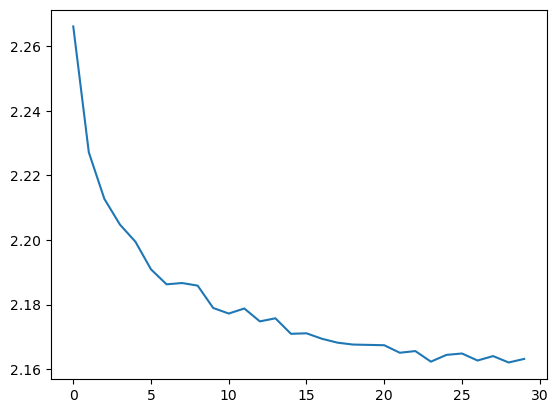

In [11]:
fit(model, 30, loss_func, optimizer, train_dl, valid_dl)

In [12]:
from statistics import fmean

results = []
model.eval()
for X, y in test_dl:
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X)
    probs = F.softmax(y_pred, dim=1)
    _, preds = torch.max(probs, dim=1)    
    results.append(((preds == y).sum().float() / BATCH_SIZE).item())

print(f'Mean Accuracy={fmean(results) * 100:0.2f}%')

Mean Accuracy=35.10%


In [14]:
preds = []
model.eval()
for i in range(10):
    context = [ltoi[START_CHAR]] * (CONTEXT_DIM - 1)
    output = ''
    while True:
        x = [ltoi[FEMALE_CHAR]] + context
        x = torch.tensor(x).unsqueeze(0)
        x = x.to(device)
        with torch.no_grad():
            y_pred = model(x)
            y_prob = y_pred.exp() / y_pred.exp().sum()
        idx = int(torch.multinomial(y_prob, num_samples=1, replacement=True).item())
        if idx == ltoi[END_CHAR]:
            break
        output += itol[idx]
        context = context[1:] + [idx]
    # preds.append(output)    
    print(output)
# print(preds)

shaan
dirah
wawaleenah
dat
jadiyepen
nuz
ruhreida
himiz
haraisra
abeet
